Input data split into vectors of sizes [131072.]
Input data split with displacements of [0.]


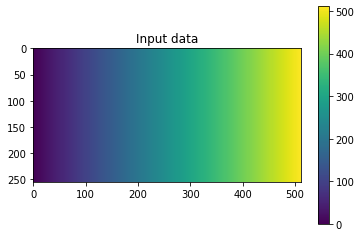

Rank 0, split shape: (256, 512)
Rank 0, my shape: (512, 512)
Rank 0 with output_chunk shape (256, 512)


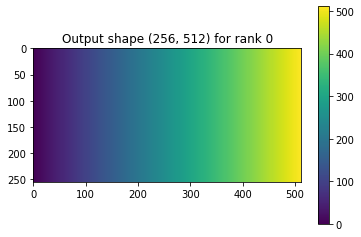

Output shape (256, 512) for rank 0


In [9]:
import numpy as np
from mpi4py import MPI
import matplotlib.pyplot as plt

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

if rank == 0:
    test = np.arange(0,512,dtype='float64')
    test = np.tile(test,[256,1]) #Create 2D input array. Numbers 1 to 512 increment across dimension 2.
    outputData = np.zeros([256,512]) #Create output array of same size
    split = np.array_split(test,size,axis = 0) #Split input array by the number of available cores

    split_sizes = []

    for i in range(0,len(split),1):
        split_sizes = np.append(split_sizes, len(split[i]))

    split_sizes_input = split_sizes*512
    displacements_input = np.insert(np.cumsum(split_sizes_input),0,0)[0:-1]

    split_sizes_output = split_sizes*512
    displacements_output = np.insert(np.cumsum(split_sizes_output),0,0)[0:-1]


    print("Input data split into vectors of sizes %s" %split_sizes_input)
    print("Input data split with displacements of %s" %displacements_input)

    plt.imshow(test)
    plt.colorbar()
    plt.title('Input data')
    plt.show()

else:
#Create variables on other cores
    split_sizes_input = None
    displacements_input = None
    split_sizes_output = None
    displacements_output = None
    split = None
    test = None
    outputData = None

split = comm.bcast(split, root=0) #Broadcast split array to other cores
split_sizes = comm.bcast(split_sizes_input, root = 0)
displacements = comm.bcast(displacements_input, root = 0)
split_sizes_output = comm.bcast(split_sizes_output, root = 0)
displacements_output = comm.bcast(displacements_output, root = 0)

print("Rank {}, split shape:".format(rank), np.shape(split[rank]))
print("Rank {}, my shape:".format(rank), (int(split_sizes[rank] / 256), 512))

#Create array to receive subset of data on each core, where rank specifies the core
# output_chunk = np.zeros((int(split_sizes[rank]), 512)) 
output_chunk = np.zeros(np.shape(split[rank]))
print("Rank %d with output_chunk shape %s" %(rank,output_chunk.shape))
comm.Scatterv([test,split_sizes_input, displacements_input,MPI.DOUBLE],output_chunk,root=0)

output = np.zeros([len(output_chunk),512]) #Create output array on each core

for i in range(0,np.shape(output_chunk)[0],1):
    output[i,0:512] = output_chunk[i]

plt.imshow(output)
plt.title("Output shape %s for rank %d" %(output.shape,rank))
plt.colorbar()
plt.show()

print("Output shape %s for rank %d" %(output.shape,rank))